# ZOD Dataset Exploration - Camera-Specific Pedestrian Prediction



In [33]:
from pathlib import Path # for file path operations
import os # for file path operations
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import json
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
import torchvision
from collections import Counter
import cv2



In [4]:
# This is the path to the ZOD256 dataset on the VM
# Its the ZOD dataset but we resized it to 256x256. 
# The original 2000x1500 are too heavy to work with, 
# 256x256 is a good spot for performance. 
# note that we will only work with the single_frames folder, 
# as we are only interested in the images and annotations for now.  
DATA_ROOT = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/")
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("Top-level contents:")
for p in sorted(DATA_ROOT.iterdir()):
    print(" -", p.name)



DATA_ROOT exists: True
Top-level contents:
 - 000000
 - 000001
 - 000002
 - 000003
 - 000004
 - 000005
 - 000006
 - 000007
 - 000008
 - 000009
 - 000010
 - 000011
 - 000012
 - 000013
 - 000014
 - 000015
 - 000016
 - 000017
 - 000018
 - 000019
 - 000020
 - 000021
 - 000022
 - 000023
 - 000024
 - 000025
 - 000026
 - 000027
 - 000028
 - 000029
 - 000030
 - 000031
 - 000032
 - 000033
 - 000034
 - 000035
 - 000036
 - 000037
 - 000038
 - 000039
 - 000040
 - 000041
 - 000042
 - 000043
 - 000044
 - 000045
 - 000046
 - 000047
 - 000048
 - 000049
 - 000050
 - 000051
 - 000052
 - 000053
 - 000054
 - 000055
 - 000056
 - 000057
 - 000058
 - 000059
 - 000060
 - 000061
 - 000062
 - 000063
 - 000064
 - 000065
 - 000066
 - 000067
 - 000068
 - 000069
 - 000070
 - 000071
 - 000072
 - 000073
 - 000074
 - 000075
 - 000076
 - 000077
 - 000078
 - 000079
 - 000080
 - 000081
 - 000082
 - 000083
 - 000084
 - 000085
 - 000086
 - 000087
 - 000088
 - 000089
 - 000090
 - 000091
 - 000092
 - 000093
 - 000094
 - 0000

## Dataset location and on-disk structure (local VM)

**Dataset root:** `/mnt/pr_2018_scaleout_workdir/ZOD256`

We will work with: 
- `single_frames` folder

### Frame folder structure
Inside `train2017/` there are ~100,000 frame folders named:
`000000/`, ... , `099999/`

Each frame folder contains:
- `annotations/` — per-frame labels (e.g., 2D/3D boxes, segmentation, etc.)
- `camera_front_blur/` — anonymized camera image (blur)
- `camera_front_dnat/` — anonymized camera image (DNAT)
- `lidar_velodyne/` — LiDAR data for the keyframe

This exploration notebook focuses on **vision-only** using the front camera images
(`camera_front_blur` / `camera_front_dnat`) and the corresponding object labels
in `annotations/`, with emphasis on **pedestrians** and condition metadata.


In [5]:

frame_id = "000000" #first frame

#first_frame_dir is a path object representing the path to the frame folder:
                        #/home/edgelab/zod_dino_data/train2017/000000
first_frame_dir = DATA_ROOT / frame_id
print("Frame dir exists:", first_frame_dir.exists()) 

# list contents
print("Frame contents:", [p.name for p in first_frame_dir.iterdir()])

# find an image in blur folder
# glob means: find files matching a pattern
blur_dir = first_frame_dir / "camera_front_blur"
blur_img_files = list(blur_dir.glob("*.jpg"))
print("First blur image file path(000000):", blur_img_files[0] if blur_img_files else None)

# Note: the dnat folder contains two images and one is resized version of the other 
# find an image in dnat folder
dnat_dir = first_frame_dir / "camera_front_dnat"
dnat_img_files = list(dnat_dir.glob("*.jpg"))


print("dnat_img_original_path:", dnat_img_files[0] if dnat_img_files else None)




Frame dir exists: True
Frame contents: ['camera_front_dnat', 'camera_front_blur', 'lidar_velodyne', 'calibration.json', 'ego_motion.json', 'metadata.json', 'info.json', 'annotations']
First blur image file path(000000): /mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/000000/camera_front_blur/000000_india_2021-04-19T10:23:10.444124Z.jpg
dnat_img_original_path: /mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg


Blur image shape: (256, 256, 3)
Dnat image shape: (256, 256, 3)


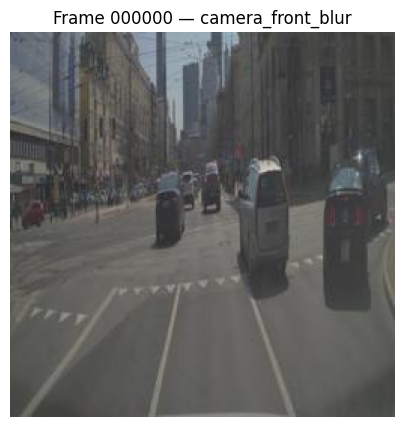

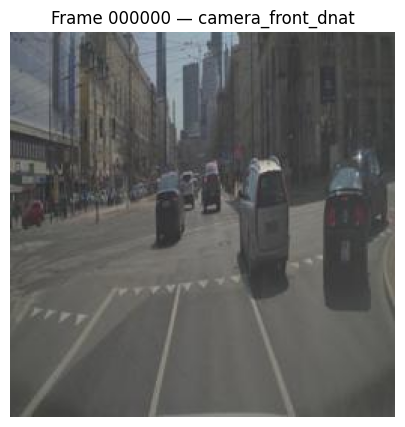

In [6]:
blur_img_path = blur_img_files[0]
dnat_img_path = dnat_img_files[0]
#imread is used to read an image from a file into a numpy array
blur_img = mpimg.imread(blur_img_path)
dnat_img = mpimg.imread(dnat_img_path)
print("Blur image shape:", blur_img.shape)
print("Dnat image shape:", dnat_img.shape)


plt.figure(figsize=(8, 5))
plt.imshow(blur_img)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_blur")
plt.show()

plt.figure(figsize=(8, 5))
plt.imshow(dnat_img)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat")
plt.show()

## Next we analyze frame-specific json files:

In [7]:

def read_json(path: Path):
    """
    Read a JSON file from disk and return it as a Python object.
    Parameters:
    - path: Path object pointing to a .json file
    Returns:
    - A Python dictionary or list (depending on the JSON content)
    """
    # first we open the file in read mode
    with open(path, "r") as file:

        # json.load reads JSON-formatted text from the file object 'file'
        # and converts it into native Python objects (dicts, lists, etc.)
        data = json.load(file)

    return data

# Read metadata describing environment conditions
metadata = read_json(first_frame_dir / "metadata.json")
#print(metadata)

# Read general info about the frame
info = read_json(first_frame_dir / "info.json")
#print(info)

print("metadata.json 000000 (keys: values)")
for k in metadata.keys():
    print(" -", k + ":", metadata[k])

metadata.json 000000 (keys: values)
 - frame_id: 000000
 - time: 2021-04-19T10:23:10.444124Z
 - country_code: PL
 - scraped_weather: partly-cloudy-day
 - collection_car: india
 - road_type: city
 - road_condition: normal
 - time_of_day: day
 - num_lane_instances: 21
 - num_vehicles: 36
 - num_vulnerable_vehicles: 5
 - num_pedestrians: 40
 - num_traffic_lights: 37
 - num_traffic_signs: 35
 - longitude: 20.993243252850032
 - latitude: 52.24205173254378
 - solar_angle_elevation: 49.17233721956617


In [8]:
print("\ninfo.json keys: values")
for k in info.keys():
    print(" -", k + ":", info[k])


info.json keys: values
 - id: 000000
 - start_time: 2021-04-19T10:23:09.306996Z
 - end_time: 2021-04-19T10:23:11.526356Z
 - keyframe_time: 2021-04-19T10:23:10.444124Z
 - calibration_path: single_frames/000000/calibration.json
 - ego_motion_path: single_frames/000000/ego_motion.json
 - metadata_path: single_frames/000000/metadata.json
 - oxts_path: single_frames/000000/oxts.hdf5
 - vehicle_data_path: None
 - annotations: {'object_detection': {'filepath': 'single_frames/000000/annotations/object_detection.json', 'project': 'object_detection'}, 'lane_markings': {'filepath': 'single_frames/000000/annotations/lane_markings.json', 'project': 'lane_markings'}, 'traffic_signs': {'filepath': 'single_frames/000000/annotations/traffic_signs.json', 'project': 'traffic_signs'}, 'road_condition': {'filepath': 'single_frames/000000/annotations/road_condition.json', 'project': 'road_condition'}}
 - camera_frames: {'front_blur': [{'filepath': 'single_frames/000000/camera_front_blur/000000_india_2021-0

## info.json (frame index file)

### Frame timing
- start_time
- end_time
- keyframe_time  
  (timestamp of the annotated camera image)

### Paths to associated data
- calibration_path
- ego_motion_path
- metadata_path
- oxts_path

### Annotations
Each annotation is referenced via a relative filepath under:
single_frames/000000/annotations/

- Object detection
- Lane markings
- Traffic signs
- Road condition


### Camera frames
- front_blur: one annotated RGB image
- front_dnat: one annotated RGB image  

Both camera images:
- correspond to the same keyframe timestamp
- have the same resolution

### LiDAR frames
- Sequence of Velodyne LiDAR scans at ~10 Hz
- Covers approximately ±1 second around the keyframe
- Stored as .npy point clouds
- All scans marked is_compensated: False


## metadata.json (scene-level metadata)

### Geography
- Country: PL
- Latitude / Longitude provided

### Environment
- Weather: partly-cloudy-day
- Time of day: day
- Road type: city
- Road condition: normal
- Solar elevation angle available

### Object counts (per keyframe)
- Vehicles: 36
- Pedestrians: 40
- Vulnerable vehicles: 5
- Traffic lights: 37
- Traffic signs: 35
- Lane instances: 21

These counts serve as a consistency check against annotation files.


# object_detection.json

In [14]:
# Object detection annotations live inside the frame folder
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
print("Object detection path:", obj_det_path)


# Reuse our existing helper (no need to re-write open/json.load every time)
obj_det = read_json(obj_det_path)
print(obj_det[0])

# type and size of obj_det contents
print("Type of obj_det:", type(obj_det))
print("Number of objects in this frame:", len(obj_det))

#HENCE, WE OBSERVE THAT WE HAVE A LIST OF DICTIONARIES, containing the annotations for each object in the frame




Object detection path: /mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/000000/annotations/object_detection.json
{'geometry': {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}}
Type of obj_det: <class 'list'>
Number of objects in this frame: 281


In [ ]:
classes = []
missing_class_count = 0

for obj in obj_det:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        missing_class_count += 1
    else:
        classes.append(cls)

print(f"Total objects in frame: {len(obj_det)}")
print(f"Objects missing properties['class']: {missing_class_count}")


class_counts = Counter(classes)

print("\nClass counts (most common first):")
for cls, cnt in class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

print(f"\nNumber of unique classes in this frame: {len(class_counts)}")


Total objects in frame: 281
Objects missing properties['class']: 0

Class counts (most common first):
Pedestrian                 57
TrafficGuide               52
PoleObject                 49
Vehicle                    46
TrafficSignal              37
TrafficSign                35
VulnerableVehicle          5

Number of unique classes in this frame: 7


In [18]:
PEDESTRIAN_CLASSES = {
    "Pedestrian",
}
pedestrian_objects = [
    obj
    for obj in obj_det
    if obj.get("properties", {}).get("class") in PEDESTRIAN_CLASSES
]

print(f"Total pedestrians in frame: {len(pedestrian_objects)}")

#now we get the first object in the list
first_obj = pedestrian_objects[1]
print(first_obj.keys())
geometry = first_obj["geometry"]
properties = first_obj["properties"]
print(geometry)
print(properties)

Total pedestrians in frame: 57
dict_keys(['geometry', 'properties'])
{'coordinates': [[1015.39, 1129.87], [1022.64, 1146.49], [1017.27, 1177.26], [1009.43, 1133.06]], 'type': 'MultiPoint'}
{'annotation_uuid': '056a0832-38be-4e2e-b2f9-2e9819aa9c34', 'class': 'Pedestrian', 'emergency': False, 'is_pulling_or_pushing': 'Nothing', 'location_3d': {'coordinates': [-34.51059867831607, 61.08653288743784, -2.753642415359497], 'type': 'Point'}, 'occlusion_ratio': 'Light', 'orientation_3d_qw': 0.9720817369906971, 'orientation_3d_qx': 0.0, 'orientation_3d_qy': 0.0, 'orientation_3d_qz': 0.23464248679458977, 'relative_position': 'NotOnEgoRoad', 'size_3d_height': 1.7329400736389164, 'size_3d_length': 0.5799706085525216, 'size_3d_width': 0.6113639909743114, 'unclear': False, 'type': 'Pedestrian'}


In [19]:
print(first_obj.keys())

geometry = first_obj["geometry"]
properties = first_obj["properties"]
print(geometry)
print(properties)
#print(geometry["coordinates"][0])

# Each element in obj_det is one annotated object (dict with keys: "geometry", "properties")

dict_keys(['geometry', 'properties'])
{'coordinates': [[1015.39, 1129.87], [1022.64, 1146.49], [1017.27, 1177.26], [1009.43, 1133.06]], 'type': 'MultiPoint'}
{'annotation_uuid': '056a0832-38be-4e2e-b2f9-2e9819aa9c34', 'class': 'Pedestrian', 'emergency': False, 'is_pulling_or_pushing': 'Nothing', 'location_3d': {'coordinates': [-34.51059867831607, 61.08653288743784, -2.753642415359497], 'type': 'Point'}, 'occlusion_ratio': 'Light', 'orientation_3d_qw': 0.9720817369906971, 'orientation_3d_qx': 0.0, 'orientation_3d_qy': 0.0, 'orientation_3d_qz': 0.23464248679458977, 'relative_position': 'NotOnEgoRoad', 'size_3d_height': 1.7329400736389164, 'size_3d_length': 0.5799706085525216, 'size_3d_width': 0.6113639909743114, 'unclear': False, 'type': 'Pedestrian'}


## Coordinate scale mismatch (ZOD256)

- In `ZOD256`, the camera images are resized to **256×256** (confirmed via `mpimg.imread(...).shape == (256, 256, 3)`).
- However, the 2D annotation coordinates in `annotations/object_detection.json` remain in the **original image coordinate system** (e.g., x/y values in the thousands).
- Therefore, to overlay boxes on the 256×256 images or to train a detector on ZOD256, we must **rescale coordinates on the fly**.

### On-the-fly coordinate rescaling

Let:
- `(W_old, H_old)` = original image width/height that the annotations refer to
- `(W_new, H_new) = (256, 256)`

Then for each annotation corner `(x, y)`:

- `x_scaled = x * (W_new / W_old)`
- `y_scaled = y * (H_new / H_old)`


In [20]:
frame_id = "000000"

# ZOD256 image filename
zod256_frame_dir = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames") / frame_id
zod256_img = sorted((zod256_frame_dir / "camera_front_dnat").glob("*.jpg"))[0]
fname = zod256_img.name

print("ZOD256 filename:", fname)

# Try to find the same filename in the original dataset copy
orig_frame_dir = Path("/home/edgelab/zod_dino_data/train2017") / frame_id
orig_img_path = orig_frame_dir / "camera_front_dnat" / fname

print("Original image path:", orig_img_path)
print("Exists:", orig_img_path.exists())

if orig_img_path.exists():
    img = Image.open(orig_img_path)
    print("Original image size (W,H):", img.size)


ZOD256 filename: 000000_india_2021-04-19T10:23:10.444124Z.jpg
Original image path: /home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg
Exists: True
Original image size (W,H): (3848, 2168)


### We rescale and visualize bounding boxes to ensure these transformations are reasonable

In [21]:
#we convert the coordinates to a numpy array for easier manipulation
points_orig = np.array(geometry["coordinates"], dtype=np.float32)
print("Original points (x,y):", points_orig)

#original and resized image paths (frame 000000):
orig_img_path = "/home/edgelab/zod_dino_data/train2017/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg"
zod256_img_path = "/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/000000/camera_front_dnat/000000_india_2021-04-19T10:23:10.444124Z.jpg"
orig_img = Image.open(orig_img_path)
zod256_img = Image.open(zod256_img_path)
W_old, H_old = orig_img.size
W_new, H_new = zod256_img.size

print("Original image size (W,H):", W_old, H_old)
print("ZOD256 image size (W,H):", W_new, H_new)

sx = W_new / W_old
sy = H_new / H_old

print("Scale factors (sx, sy):", sx, sy)

# Copy to avoid modifying original data
points_scaled = points_orig.copy()

# x coordinates are in column 0
points_scaled[:, 0] *= sx
# y coordinates are in column 1
points_scaled[:, 1] *= sy

print("Scaled points (x,y):", points_scaled)



Original points (x,y): [[1015.39 1129.87]
 [1022.64 1146.49]
 [1017.27 1177.26]
 [1009.43 1133.06]]
Original image size (W,H): 3848 2168
ZOD256 image size (W,H): 256 256
Scale factors (sx, sy): 0.06652806652806653 0.11808118081180811
Scaled points (x,y): [[ 67.55193  133.41638 ]
 [ 68.03426  135.37889 ]
 [ 67.67701  139.01225 ]
 [ 67.155426 133.79308 ]]


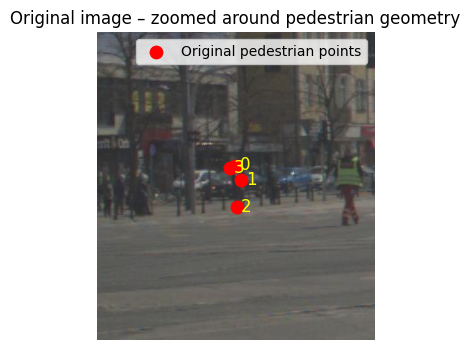

In [28]:
# ------------------------------------------------------------
# Zoom-in around original pedestrian points (original image)
# ------------------------------------------------------------


# Compute tight bounding box around the points
x_min, y_min = points_orig.min(axis=0)
x_max, y_max = points_orig.max(axis=0)

# Add padding so we see context (person + surroundings)
pad = 150  # pixels — feel free to increase/decrease

# Clamp to image boundaries
x0 = max(0, int(x_min - pad))
y0 = max(0, int(y_min - pad))
x1 = min(W_old - 1, int(x_max + pad))
y1 = min(H_old - 1, int(y_max + pad))

# ------------------------------------------------------------
# Plot zoomed original image
# ------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(orig_img)

# Overlay original points
ax.scatter(
    points_orig[:, 0],
    points_orig[:, 1],
    c="red",
    s=80,
    label="Original pedestrian points"
)

# Label each point (useful when points overlap)
for i, (x, y) in enumerate(points_orig):
    ax.text(x + 5, y + 5, str(i), fontsize=12, color="yellow")

# Zoom limits (note: y-axis inverted for images)
ax.set_xlim(x0, x1)
ax.set_ylim(y1, y0)

ax.set_title("Original image – zoomed around pedestrian geometry")
ax.axis("off")
ax.legend()

plt.show()


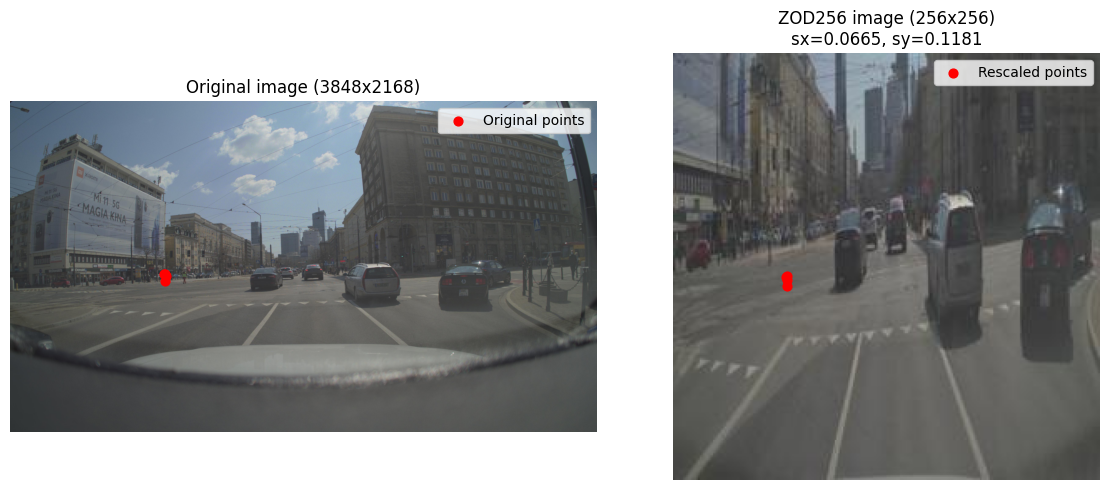

In [29]:
# ------------------------------------------------------------
# Visualization OF BOTH IMAGES 
# ------------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Original image ----
axes[0].imshow(orig_img)
axes[0].scatter(
    points_orig[:, 0],
    points_orig[:, 1],
    c="red",
    s=40,
    label="Original points",
)
axes[0].set_title(f"Original image ({W_old}x{H_old})")
axes[0].axis("off")
axes[0].legend()

# ---- ZOD256 image ----
axes[1].imshow(zod256_img)
axes[1].scatter(
    points_scaled[:, 0],
    points_scaled[:, 1],
    c="red",
    s=40,
    label="Rescaled points",
)
axes[1].set_title(
    f"ZOD256 image ({W_new}x{H_new})\n"
    f"sx={sx:.4f}, sy={sy:.4f}"
)
axes[1].axis("off")
axes[1].legend()

plt.tight_layout()
plt.show()


#### We see that the pedestrian boudning box looks reasonable in the original image, but completely off in the resized version. Perhaps there's some additional preprocessing other than pure rescaling. We can check this by rescalcing the original image and comparing with z256 version:

Mean absolute pixel difference (ZOD256 vs PIL-resize(original)): 28.51355489095052


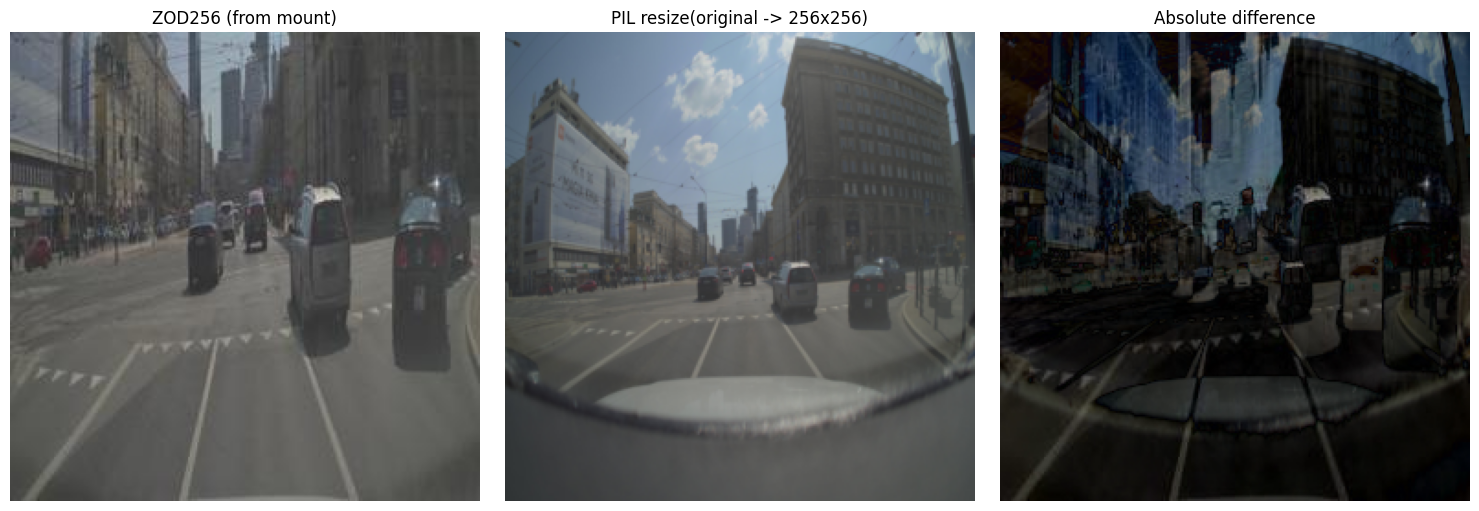

In [23]:

# Load original and ZOD256
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Create "our own ZOD256" by resizing the full original to 256x256
# (this matches the assumption behind sx=W_new/W_old and sy=H_new/H_old)
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to arrays for numeric comparison
A = np.asarray(z256).astype(np.int16)
B = np.asarray(orig_resized).astype(np.int16)

# Compute mean absolute pixel difference (0 means identical)
mad = np.mean(np.abs(A - B))
print("Mean absolute pixel difference (ZOD256 vs PIL-resize(original)):", mad)

# Visualize side-by-side + difference image
diff = np.abs(A - B).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(z256); axes[0].set_title("ZOD256 (from mount)"); axes[0].axis("off")
axes[1].imshow(orig_resized); axes[1].set_title("PIL resize(original -> 256x256)"); axes[1].axis("off")
axes[2].imshow(diff); axes[2].set_title("Absolute difference"); axes[2].axis("off")
plt.tight_layout()
plt.show()


We observe quite a large difference, indicating there's some other preperocessing at play. This means our current mapping is not the right transform for ZOD256. 

#### We test alternative cropping hypotheses:

Hypothesis comparison (lower MAD is better):
direct_resize                       MAD = 28.5136
right_crop_square_then_resize       MAD = 28.6456
center_crop_square_then_resize      MAD = 32.7188
left_crop_square_then_resize        MAD = 38.3195

Best hypothesis: direct_resize (MAD=28.5136)


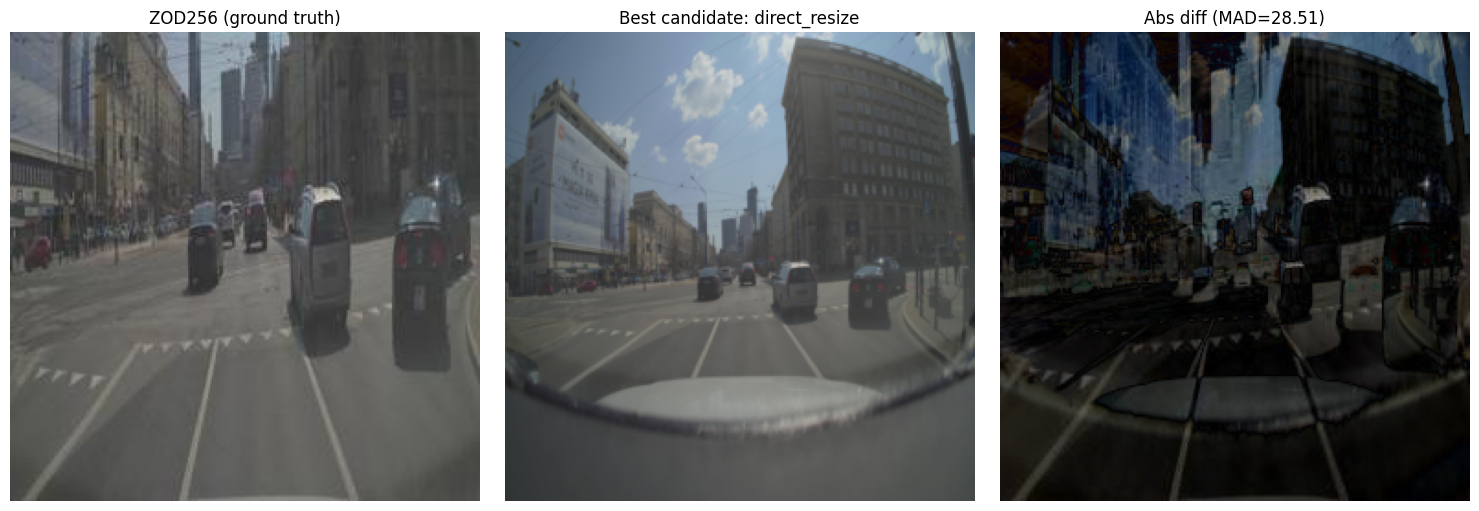

In [31]:
best_img = candidates[best_name]
best_diff = diffs[best_name]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(z256)
axes[0].set_title("ZOD256 (ground truth)")
axes[0].axis("off")

axes[1].imshow(best_img)
axes[1].set_title(f"Best candidate: {best_name}")
axes[1].axis("off")

axes[2].imshow(best_diff)
axes[2].set_title(f"Abs diff (MAD={best_mad:.2f})")
axes[2].axis("off")

plt.tight_layout()
plt.show()


ECC correlation coefficient: 0.9820716810957656
Estimated affine warp matrix:
 [[7.3790801e-01 1.6754445e-04 3.3133663e+01]
 [1.4121797e-05 3.6794728e-01 9.4260803e+01]]


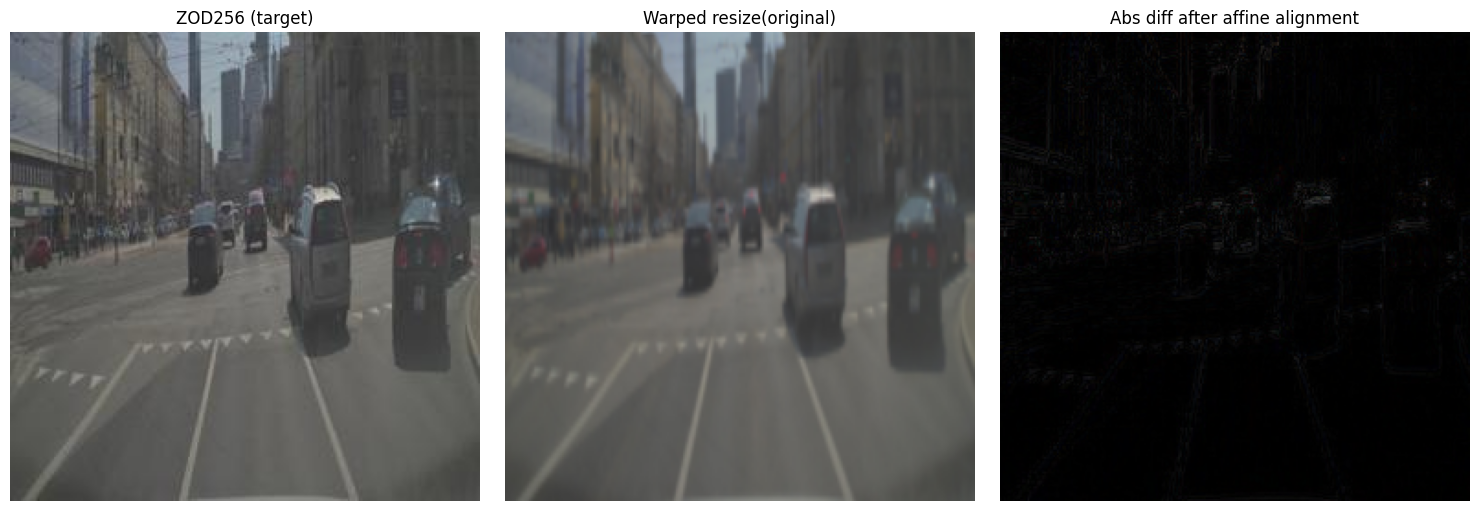

In [34]:
# Load images
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Make the "direct resize" candidate (256x256)
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to grayscale float32 in [0,1] (ECC expects float images)
I = np.asarray(orig_resized).astype(np.uint8)
J = np.asarray(z256).astype(np.uint8)

I_gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
J_gray = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

# ECC settings
warp_mode = cv2.MOTION_AFFINE         # affine: translation + rotation + scale + shear
warp_matrix = np.eye(2, 3, dtype=np.float32)

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)

# Estimate warp that maps I_gray -> J_gray
cc, warp_matrix = cv2.findTransformECC(
    templateImage=J_gray,     # target
    inputImage=I_gray,        # source
    warpMatrix=warp_matrix,
    motionType=warp_mode,
    criteria=criteria,
    inputMask=None,
    gaussFiltSize=5
)

print("ECC correlation coefficient:", cc)
print("Estimated affine warp matrix:\n", warp_matrix)

# Apply warp to the resized original to see if it aligns with ZOD256
I_warp = cv2.warpAffine(I, warp_matrix, (256, 256), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

# Visualize: ZOD256, warped candidate, and absolute difference
diff = cv2.absdiff(np.asarray(z256), I_warp)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(z256); axes[0].set_title("ZOD256 (target)"); axes[0].axis("off")
axes[1].imshow(I_warp); axes[1].set_title("Warped resize(original)"); axes[1].axis("off")
axes[2].imshow(diff); axes[2].set_title("Abs diff after affine alignment"); axes[2].axis("off")
plt.tight_layout()
plt.show()


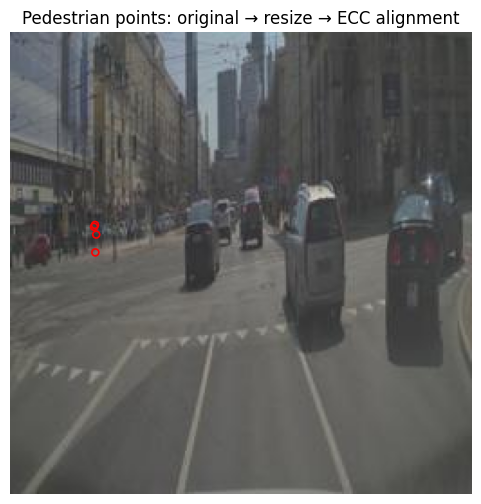

In [38]:
# points_orig: (N,2) in ORIGINAL image pixel coords (3848x2168)
# orig: PIL original image
# z256: PIL ZOD256 image
# warp_matrix: 2x3 from ECC

import numpy as np
import matplotlib.pyplot as plt

W_old, H_old = orig.size

# ------------------------------------------------------------
# Map original points -> "resized original" (256x256) coords
# ------------------------------------------------------------
sx = 256 / W_old
sy = 256 / H_old

points_resize = points_orig.copy().astype(np.float32)
points_resize[:, 0] *= sx
points_resize[:, 1] *= sy

# ------------------------------------------------------------
# Convert ECC affine 2x3 to full 3x3 homogeneous matrix
# ------------------------------------------------------------
M = np.eye(3, dtype=np.float32)
M[:2, :] = warp_matrix

# ------------------------------------------------------------
# Invert it (because image warp used WARP_INVERSE_MAP)
# ------------------------------------------------------------
M_inv = np.linalg.inv(M)

# ------------------------------------------------------------
# Apply inverse affine to points (homogeneous coords)
# ------------------------------------------------------------
ones = np.ones((points_resize.shape[0], 1), dtype=np.float32)
pts_h = np.concatenate([points_resize, ones], axis=1)   # (N,3)

points_aligned_h = (M_inv @ pts_h.T).T                  # (N,3)
points_aligned = points_aligned_h[:, :2]                # (N,2)

# ------------------------------------------------------------
# Plot on ZOD256 (small, unobtrusive markers)
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(z256)

# Small hollow circles so image content remains visible
ax.scatter(
    points_aligned[:, 0],
    points_aligned[:, 1],
    s=25,
    facecolors="none",
    edgecolors="red",
    linewidths=1.2
)


ax.set_title("Pedestrian points: original → resize → ECC alignment")
ax.axis("off")
plt.show()


ECC correlation coefficient: 0.9820716810957656
MAD baseline (direct_resize): 28.51355489095052
MAD aligned  (resize + ECC):  3.102605183919271


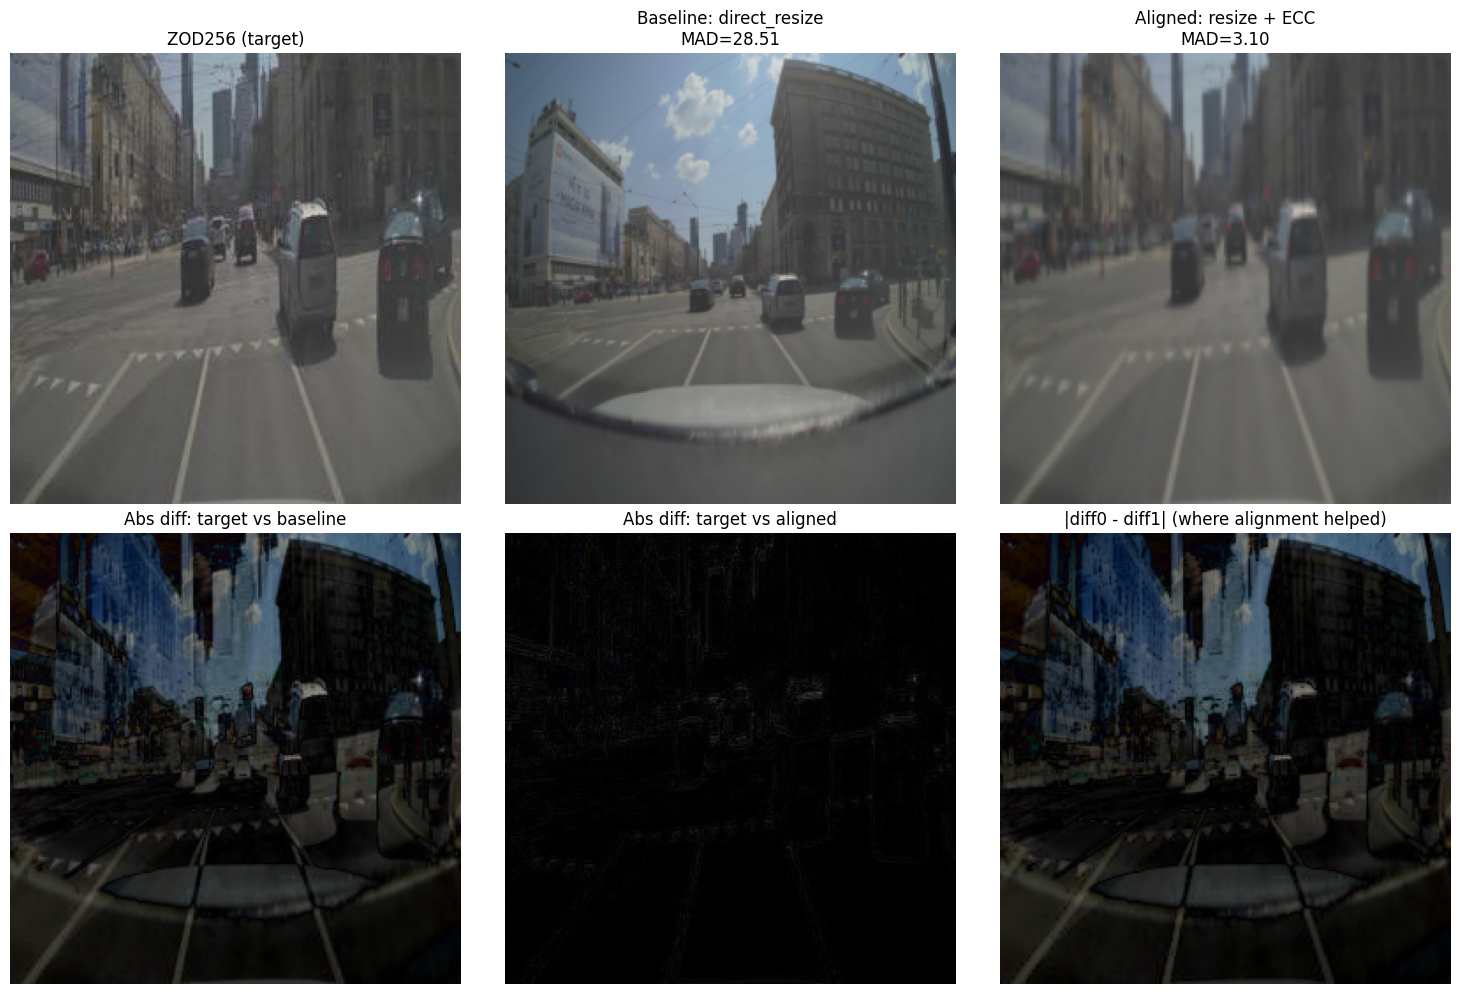

In [37]:


# Load images
orig = Image.open(orig_img_path).convert("RGB")
z256 = Image.open(zod256_img_path).convert("RGB")

# Baseline candidate: direct resize of original to 256x256
orig_resized = orig.resize((256, 256), resample=Image.BILINEAR)

# Convert to numpy
A = np.asarray(z256).astype(np.int16)          # target
B0 = np.asarray(orig_resized).astype(np.int16) # baseline

# ----------------------------
# Compute ECC warp (same as you already did)
# ----------------------------
I = np.asarray(orig_resized).astype(np.uint8)
J = np.asarray(z256).astype(np.uint8)

I_gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
J_gray = cv2.cvtColor(J, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

warp_matrix = np.eye(2, 3, dtype=np.float32)
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)

cc, warp_matrix = cv2.findTransformECC(
    templateImage=J_gray,
    inputImage=I_gray,
    warpMatrix=warp_matrix,
    motionType=cv2.MOTION_AFFINE,
    criteria=criteria,
    inputMask=None,
    gaussFiltSize=5
)

# IMPORTANT: to be consistent with what you did before, use WARP_INVERSE_MAP
I_warp = cv2.warpAffine(
    I,
    warp_matrix,
    (256, 256),
    flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
)

B1 = I_warp.astype(np.int16)  # aligned candidate

# ----------------------------
# Compute MADs
# ----------------------------
diff0 = np.abs(A - B0).astype(np.uint8)
diff1 = np.abs(A - B1).astype(np.uint8)

mad0 = float(np.mean(diff0))
mad1 = float(np.mean(diff1))

print("ECC correlation coefficient:", cc)
print("MAD baseline (direct_resize):", mad0)
print("MAD aligned  (resize + ECC): ", mad1)

# ----------------------------
# Visualize: target, baseline, aligned, and their diffs
# ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(z256)
axes[0, 0].set_title("ZOD256 (target)")
axes[0, 0].axis("off")

axes[0, 1].imshow(orig_resized)
axes[0, 1].set_title(f"Baseline: direct_resize\nMAD={mad0:.2f}")
axes[0, 1].axis("off")

axes[0, 2].imshow(I_warp)
axes[0, 2].set_title(f"Aligned: resize + ECC\nMAD={mad1:.2f}")
axes[0, 2].axis("off")

axes[1, 0].imshow(diff0)
axes[1, 0].set_title("Abs diff: target vs baseline")
axes[1, 0].axis("off")

axes[1, 1].imshow(diff1)
axes[1, 1].set_title("Abs diff: target vs aligned")
axes[1, 1].axis("off")

# Difference of differences (helps see improvement regions)
# Large values here mean ECC alignment changed pixel placement a lot (usually a good sign)
dod = np.abs(diff0.astype(np.int16) - diff1.astype(np.int16)).astype(np.uint8)
axes[1, 2].imshow(dod)
axes[1, 2].set_title("|diff0 - diff1| (where alignment helped)")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


#### Given the added complexity here and unclear benefit to predicting multipoint bounding boxes for pedestrian prediction, I will stick to classifying pedestrian presence for now instead. 

## Counts per class:

In [9]:
# Each element in obj_det is one annotated object (dict with keys: "geometry", "properties")

classes_in_frame = set({obj["properties"]["class"] for obj in obj_det})

# initialize dict to count per class
count_per_class = {c: 0 for c in classes_in_frame}

for obj in obj_det:
    count_per_class[obj["properties"]["class"]] += 1

print(f"Number of unique classes in frame {frame_id}: {len(classes_in_frame)}")
for c, count in count_per_class.items():
    print(" -", c + ":", count)


print("Number of annotated objects in this frame:", len(obj_det))








Number of unique classes in frame 000000: 7
 - TrafficSignal: 37
 - TrafficGuide: 52
 - VulnerableVehicle: 5
 - Vehicle: 46
 - PoleObject: 49
 - Pedestrian: 57
 - TrafficSign: 35
Number of annotated objects in this frame: 281


We have a mismatch ---- in metadata we see num_pedestrians = 40, as opposed to 57 in annotations. 


In [32]:
# Helper: identify if an object is a pedestrian
def is_pedestrian(obj):
    return obj["properties"].get("class") == "Pedestrian"

# Pull all pedestrians in this frame
peds = [obj for obj in obj_det if is_pedestrian(obj)]
print("Pedestrians (raw from object_detection.json):", len(peds))

peds_not_unclear = [obj for obj in peds if not obj["properties"].get("unclear", False)]
print("Pedestrians with unclear == False:", len(peds_not_unclear))

# Occlusion ratio distribution (how many None/Medium/Heavy)
occ_counts = Counter([obj["properties"].get("occlusion_ratio") for obj in peds])
print("Pedestrian occlusion_ratio counts:", dict(occ_counts))


Pedestrians (raw from object_detection.json): 57
Pedestrians with unclear == False: 40
Pedestrian occlusion_ratio counts: {'VeryHeavy': 3, 'Light': 18, 'Heavy': 9, 'Medium': 5, None: 17, 'None': 5}


#### This means that metadata is only counting pedestrians with properties["unclear"] == False, wheras annotations coutns all pedestrians regardless of the "unclear" label. "unclear" means that the annotator isn’t confident / it’s ambiguous  ie low quality label.

- To maximize recall / robustness early, perhaps it's wise to include all pedestrians.

- Option A: Binary pedestrian presence likely too simple... Likely highly imbalanced (mostly 1s). Not very informative in dense urban scenes.
- Option B: Pedestrian count (regression or classification)
    - Much richer signal
    - Still avoids geometry headaches
- Option C: Thresholded presence (“crowdedness”)
    - ex: 0: none, 1: few (1–5), 2: many (6–15), 3: crowded (16+). 


## Weather conditions analysis:

In [73]:
weather_values = []

# Get all frame IDs
frame_ids = sorted([p.name for p in TRAIN_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_ids)

for fid in frame_ids:
    meta = read_json(TRAIN_ROOT / fid / "metadata.json")
    weather_values.append(meta.get("scraped_weather", None))

# Count weather occurrences
weather_counts = Counter(weather_values)

print(f"Total frames scanned: {total_frames}")
print("Weather distribution:")

for w, cnt in weather_counts.most_common():
    percentage = 100.0 * cnt / total_frames
    print(f" - {w}: {cnt} ({percentage:.2f}%)")


Total frames scanned: 100000
Weather distribution:
 - partly-cloudy-day: 29153 (29.15%)
 - cloudy: 18991 (18.99%)
 - clear-day: 16441 (16.44%)
 - rain: 15716 (15.72%)
 - partly-cloudy-night: 11124 (11.12%)
 - clear-night: 3999 (4.00%)
 - fog: 2117 (2.12%)
 - snow: 1972 (1.97%)
 - wind: 487 (0.49%)


### Pedestrian bounding-box size distribution
- measure of distribution of pedestrian distance across frames dataset

In [ ]:
# load object_detection.json for one frame (000000)
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
obj_det = read_json(obj_det_path)   # list of dicts

# find the first pedestrian object ---
ped_obj = None
for obj in obj_det:
    if obj["properties"].get("class") == "Pedestrian":
        ped_obj = obj
        break

print("Found pedestrian:", ped_obj is not None)

# extract the 4 bbox corner points
corners = ped_obj["geometry"]["coordinates"]
print("Corners (4 points):", corners)

# compute xmin/xmax/ymin/ymax ---
xs = [p[0] for p in corners]
ys = [p[1] for p in corners]

xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

width  = xmax - xmin
height = ymax - ymin

print("xmin, ymin, xmax, ymax:", xmin, ymin, xmax, ymax)
print("width, height:", width, height)


Found pedestrian: True
Corners (4 points): [[1610.16, 1102.42], [1615.43, 1112.06], [1610.85, 1132.92], [1604.43, 1112.06]]
xmin, ymin, xmax, ymax: 1604.43 1102.42 1615.43 1132.92
width, height: 11.0 30.5


### Pedestrian occlusion distribution